In [2]:
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

from ae_pricing.data import GKXDataLoader#, StockSeqDataLoader
#from ae_pricing.model import FactorModel, BetaModel, AssetPricingModel, MeanEnsemble
from ae_pricing.eval import total_r2_score, pred_r2_score
from ae_pricing.utils import l1_reg_loss


def tuple_arr_to_tensor(arrs, dtype, device):
    return tuple(torch.from_numpy(arr).to(dtype=dtype, device=device) for arr in arrs)

device = torch.device("cuda:1")

In [7]:
dloader = GKXDataLoader(data_dir="stockmonth_rn.npz")

Loading data...


In [9]:
dloader.rets

{19850131: array([[0.3114754 ],
        [0.08333334],
        [0.44038463],
        ...,
        [0.0106383 ],
        [0.42857143],
        [0.54545456]], dtype=float32),
 19850228: array([[ 0.2       ],
        [-0.03846154],
        [-0.01342282],
        ...,
        [ 0.28421053],
        [-0.01666667],
        [ 0.05882353]], dtype=float32),
 19850329: array([[-0.08333334],
        [ 0.        ],
        [-0.15646258],
        ...,
        [-0.19672132],
        [-0.03389831],
        [ 0.30555555]], dtype=float32),
 19850430: array([[ 0.11363637],
        [-0.02      ],
        [-0.05806452],
        ...,
        [ 0.10204082],
        [-0.02631579],
        [-0.06382979]], dtype=float32),
 19850531: array([[-0.04081633],
        [ 0.2244898 ],
        [-0.00862069],
        ...,
        [-0.01851852],
        [-0.00900901],
        [ 0.29545453]], dtype=float32),
 19850628: array([[ 0.10638298],
        [ 0.        ],
        [ 0.17391305],
        ...,
        [-0.16981132],
 

In [5]:
dloader.da

array([19630131, 19630228, 19630329, 19630430, 19630531, 19630628,
       19630731, 19630830, 19630930, 19631031, 19631129, 19631231,
       19640131, 19640228, 19640331, 19640430, 19640528, 19640630,
       19640731, 19640831, 19640930, 19641030, 19641130, 19641231,
       19650129, 19650226, 19650331, 19650430, 19650528, 19650630,
       19650730, 19650831, 19650930, 19651029, 19651130, 19651231,
       19660131, 19660228, 19660331, 19660429, 19660531, 19660630,
       19660729, 19660831, 19660930, 19661031, 19661130, 19661230,
       19670131, 19670228, 19670331, 19670428, 19670531, 19670630,
       19670731, 19670831, 19670929, 19671031, 19671130, 19671229,
       19680131, 19680229, 19680329, 19680430, 19680531, 19680628,
       19680730, 19680830, 19680930, 19681031, 19681129, 19681231,
       19690131, 19690228, 19690328, 19690430, 19690529, 19690630,
       19690731, 19690829, 19690930, 19691031, 19691128, 19691231,
       19700130, 19700227, 19700331, 19700430, 19700529, 19700

In [6]:
dloader.save("raw_data/data_mynew_shifted.npz")

In [3]:
dloader = StockSeqDataLoader(StockSeqDataLoader.Config(
            data_path='raw_data/data_mynp.npz', batch_size=1, stock_size=512, seq_len=1
        ))

Loading data...


In [4]:
g = dloader.get_split(("1930-01-01", "1990-01-01"))

In [10]:
c, r = next(g)

In [11]:
c.shape, r.shape

((512, 94), (512,))

(array([6688., 3791., 3655., 3705., 7868., 8295., 3526., 3483., 3293.,
        3824.]),
 array([-5.00003401e-01, -4.00002734e-01, -3.00002067e-01, -2.00001399e-01,
        -1.00000732e-01, -6.44481175e-08,  1.00000603e-01,  2.00001270e-01,
         3.00001938e-01,  4.00002605e-01,  5.00003272e-01]),
 <BarContainer object of 10 artists>)

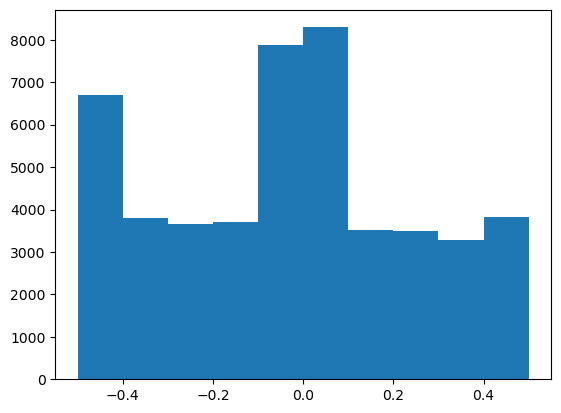

In [16]:
plt.hist(c.flatten())

In [2]:
(
    1
    +2
)

3

In [ ]:
torch.distributions.Categorical

In [2]:
dloader = GKXDataLoader("stockmonth_rn.npz")
train_dloader, val_dloader, test_dloader, _ = dloader.split([20050101, 20060101, 20070101])

def infinite_iter(it):
    while True:
        for i in it:
            yield i

train_batch_gen = infinite_iter(train_dloader)
val_batch_gen = infinite_iter(val_dloader)
test_batch_gen = infinite_iter(test_dloader)

get_train_batch = lambda: next(train_batch_gen)
get_val_batch = lambda: next(val_batch_gen)
get_test_batch = lambda: next(test_batch_gen)

Loading data...


In [3]:
NUM_FACTORS = 5
N_ENSEMBLE = 10
num_chrs = train_dloader[0][0].shape[1]


model = MeanEnsemble([
    AssetPricingModel(
        beta_arch=[32, 16, 8], factor_arch=[], num_chrs=num_chrs, num_factors=NUM_FACTORS
    )  for _ in range(N_ENSEMBLE)
]).to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
chrs, rets = tuple_arr_to_tensor(get_train_batch(), dtype=torch.float32, device=device)


In [10]:
losses = []
r2s = []
val_steps = []
val_losses = []
val_r2s = []
val_freq = 1

loss_fn = torch.nn.MSELoss()

In [14]:
pbar = tqdm.trange(4000)

def infinite_iter(it):
    while True:
        for i in it:
            yield i

train_batch_gen = infinite_iter(train_dloader)
val_batch_gen = infinite_iter(val_dloader)
get_train_batch = lambda: next(train_batch_gen)
get_val_batch = lambda: next(val_batch_gen)

for step in pbar:
    model.train()
    chrs, rets = tuple_arr_to_tensor(get_train_batch(), dtype=torch.float32, device=device)
    # (B, P), (B, 1)

    optim.zero_grad()
    
    port_rets = torch.matmul(torch.matmul(torch.linalg.inv(torch.matmul(chrs.T, chrs)), chrs.T), rets).T  # (batch_size, 1)
    port_rets = torch.broadcast_to(port_rets, chrs.shape)  # (batch_size, characteristics)

    pred_rets, betas, factors, port_rets = model.forward(chrs, rets)

    loss = loss_fn(pred_rets, rets) + l1_reg_loss(model, factor=1e-5 / N_ENSEMBLE)
    loss.backward()

    optim.step()

    r2s.append(1 - (pred_rets - rets).square().sum().item() / rets.square().sum().item())
    losses.append(loss.item())

    if step % val_freq == 0:
        model.eval()
        with torch.no_grad():
            chrs, rets = tuple_arr_to_tensor(get_val_batch(), dtype=torch.float32, device=device)
            port_rets = torch.matmul(torch.matmul(torch.linalg.inv(torch.matmul(chrs.T, chrs)), chrs.T), rets).T  # (batch_size, 1)
            port_rets = torch.broadcast_to(port_rets, chrs.shape)  # (batch_size, characteristics)
            pred_rets, betas, factors, port_rets = model.forward(chrs, rets)
            val_loss = loss_fn(pred_rets, rets)

            val_r2s.append(1 - (pred_rets - rets).square().sum().item() / rets.square().sum().item())

            val_losses.append(val_loss.item())
            val_steps.append(step)
            
        pbar.set_description(f"train loss: {np.mean(losses[-100:]): .6f}, val loss: {np.mean(val_losses[-100:]):.6f}")

train loss:  0.033845, val loss: 0.016755: 100%|██████████| 4000/4000 [02:24<00:00, 27.77it/s]


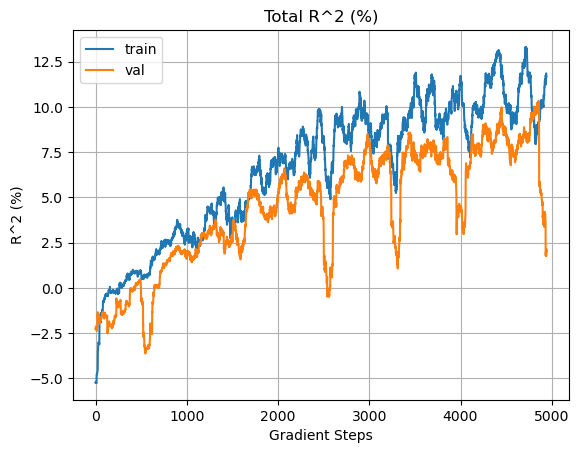

In [18]:
plt.plot(np.convolve(r2s, np.ones(100)/100, mode='valid') * 100, label='train')
plt.plot(np.convolve(val_r2s, np.ones(100)/100, mode='valid') * 100, label='val')
plt.title("Total R^2 (%)")
plt.xlabel("Gradient Steps")
plt.ylabel("R^2 (%)")
plt.legend()
plt.grid()

In [21]:
from typing import Any, Sequence

@torch.no_grad()
def pred_r2_score(model: AssetPricingModel, dloader: GKXDataLoader, train_indices: Sequence[int],
                   target_indices: Sequence[int], device: Any="cpu") -> float:
    """
    Computes R2 score of the model on the given data loader.
    Indices should be aligned chronologically, to correctly calculate the predictive factors.
    """
    model = model.eval().to(device)

    ret_squareds = 0.0
    pred_squareds = 0.0
    
    # calculate factors first
    factors = []
    for date in train_indices:
        chrs, rets = dloader.chrs[date], dloader.rets[date]
        chrs, rets = torch.from_numpy(chrs).float().to(device, non_blocking=True), torch.from_numpy(rets).float().to(device, non_blocking=True)
        _, _, factor, _ = model(chrs, rets)
        factors.append(factor)

    predictive_factor = torch.stack(factors, dim=0).mean(dim=0, keepdim=True)

    for i, date in enumerate(target_indices[1:]):
        chrs, rets = dloader.chrs[date], dloader.rets[date]
        chrs, rets = torch.from_numpy(chrs).float().to(device, non_blocking=True), torch.from_numpy(rets).float().to(device, non_blocking=True)

        ret_squareds += rets.square().sum().item()
        _, betas, true_factor, _ = model(chrs, rets)

        pred_rets = (betas * predictive_factor).sum(dim=1, keepdim=True)
        pred_squareds += (pred_rets - rets).square().sum().item()

    return 1 - pred_squareds / ret_squareds

In [26]:
pred_r2_score(model, dloader, train_dloader.dates, test2_dloader.dates, device=device) * 100

0.050820193548184456

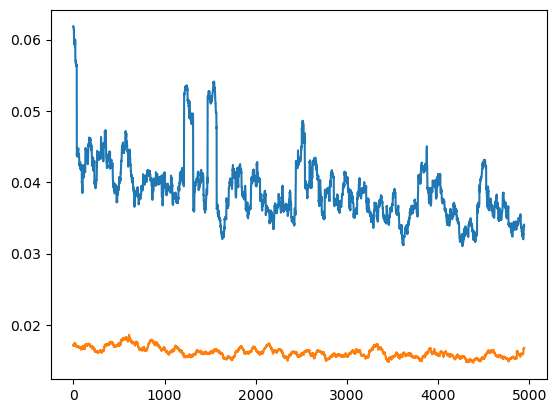

In [20]:
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.plot(np.convolve(val_losses, np.ones(100)/100, mode='valid'))